Found existing installation: tensorflow 2.17.1
Uninstalling tensorflow-2.17.1:
  Successfully uninstalled tensorflow-2.17.1
  Cloning https://github.com/mindee/doctr.git to /tmp/pip-install-u6r43v5e/python-doctr_e9b22641714e418a977e5c0c603dae16
  Running command git clone --filter=blob:none --quiet https://github.com/mindee/doctr.git /tmp/pip-install-u6r43v5e/python-doctr_e9b22641714e418a977e5c0c603dae16
  Resolved https://github.com/mindee/doctr.git to commit 83f1bc587bc809b08212acc9922506df92d53030
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.5/48.5 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 40.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 91.7 MB/s eta 0:0

Saving 12345.png to 12345.png


  0%|          | 0/102021912 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/doctr/models/utils/pytorch.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(archive_path, map_location="c

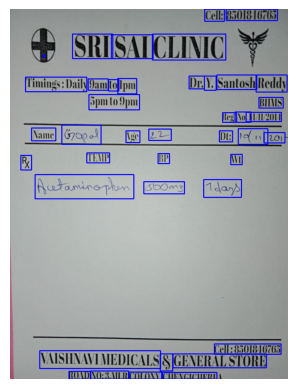

In [1]:
# Uninstall the preinstalled tensorflow version if we want to work with PyTorch as backend
!pip uninstall -y tensorflow
# Install doctr
!pip install python-doctr[torch,viz]@git+https://github.com/mindee/doctr.git

# Imports
import requests
import numpy as np
from matplotlib import pyplot as plt
import cv2
from google.colab import files
from doctr.models import detection_predictor, recognition_predictor, page_orientation_predictor, crop_orientation_predictor
from doctr.io import DocumentFile
from doctr.utils.geometry import detach_scores
import tempfile

# Helper function to convert relative coordinates to absolute pixel values
def _to_absolute(geom, img_shape: tuple[int, int]) -> list[list[int]]:
    h, w = img_shape
    if len(geom) == 2:  # Assume straight pages = True -> [[xmin, ymin], [xmax, ymax]]
        (xmin, ymin), (xmax, ymax) = geom
        xmin, xmax = int(round(w * xmin)), int(round(w * xmax))
        ymin, ymax = int(round(h * ymin)), int(round(h * ymax))
        return [[xmin, ymin], [xmax, ymin], [xmax, ymax], [xmin, ymax]]
    else:  # For polygons, convert each point to absolute coordinates
        return [[int(point[0] * w), int(point[1] * h)] for point in geom]

# Upload an image from the local directory
uploaded_files = files.upload()

# Assuming you uploaded one image, get its filename
uploaded_filename = list(uploaded_files.keys())[0]

# Read the uploaded image
receipt_image = cv2.imdecode(np.frombuffer(uploaded_files[uploaded_filename], np.uint8), cv2.IMREAD_COLOR)

# Save the uploaded image to a temporary file
with tempfile.NamedTemporaryFile(suffix=".png", delete=False) as temp_file:
    temp_filename = temp_file.name
    cv2.imwrite(temp_filename, receipt_image)

# Define the detection predictor
det_predictor = detection_predictor(
    arch="db_resnet50",
    pretrained=True,
    assume_straight_pages=True,
    symmetric_pad=True,
    preserve_aspect_ratio=True,
    batch_size=1,
)  # .cuda().half()  # Uncomment this line if you have a GPU

# Define the postprocessing parameters (optional)
det_predictor.model.postprocessor.bin_thresh = 0.3
det_predictor.model.postprocessor.box_thresh = 0.1

# Load the document image from the temporary file
docs = DocumentFile.from_images([temp_filename])
results = det_predictor(docs)
for doc, res in zip(docs, results):
    img_shape = (doc.shape[0], doc.shape[1])
    # Detach the probability scores from the results
    detached_coords, prob_scores = detach_scores([res.get("words")])

    for i, coords in enumerate(detached_coords[0]):
        coords = coords.reshape(2, 2).tolist() if coords.shape == (4,) else coords.tolist()

        # Convert relative to absolute pixel coordinates
        points = np.array(_to_absolute(coords, img_shape), dtype=np.int32).reshape((-1, 1, 2))

        # Draw the bounding box on the image
        cv2.polylines(receipt_image, [points], isClosed=True, color=(255, 0, 0), thickness=2)

# Display the image with bounding boxes
%matplotlib inline
plt.imshow(cv2.cvtColor(receipt_image, cv2.COLOR_BGR2RGB)); plt.axis('off'); plt.show()
